In [1]:
from mpmath import hyp0f1, mp, mpf #for computing hyp0f1 in method 1 (Bessel)
from numpy.polynomial.legendre import leggauss  # Gaussian quadrature

import torch
default_dtype = torch.float32
torch.set_default_dtype(default_dtype)
from torch import exp, log, lgamma, sqrt, sin, cos, pi, tensor, sinc, linspace, arange
SQRT_2 = torch.tensor(2.0).sqrt().item()
PI = torch.tensor(torch.pi).item()
SQRT_PI = torch.tensor(torch.pi).sqrt().item()

import numpy as np
from scipy import special
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2.5
from time import time

Code for generating the figures


1.   Normalization constant $c_d$
2.   Scaling of coefficients $a_{n,k}$ ins $\mathcal{S}_d^{-1}$
3.   Weight function of uniform samples from $B_1(0)$
4.   Hypergeometric function $\eta_d$



## Figure 1: Normalization $c_d$

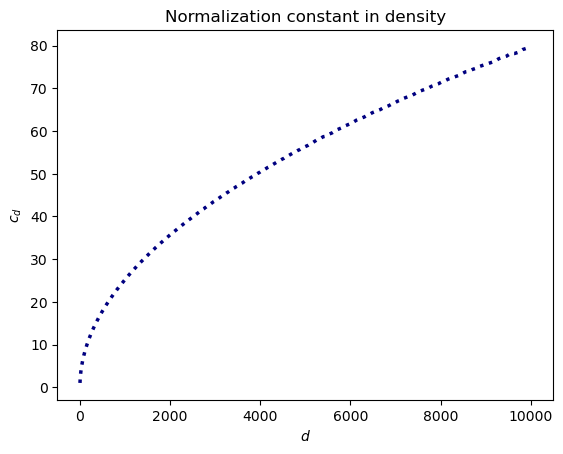

In [2]:
def get_c(d):
    """@return torch float: normalization of RLFI c_d for int d"""
    return 2./sqrt(tensor([pi])) * exp(lgamma(d/2)-lgamma((d-1)/2))

D = torch.logspace(0, 4, 1000).round().unique()[2:]
cD = get_c(D)
np.savetxt("../cd_1e4.dat", np.column_stack((D.numpy(), cD.numpy())))
plt.plot(D, cD, color="navy", linestyle="dotted")
plt.xlabel(r"$d$")
plt.ylabel(r"$c_d$")
plt.title("Normalization constant in density")
plt.show()

## Figure 2: Scaling coefficients $a_{n,k}$ of $\mathcal S_d^{-1}$


The recurrence relation \eqref{eq:ank_recursion} is numerically cumbersome as the coefficients $a_{n,k}$ increase super exponentially with $d$. Define the decline of $a_{m,k}$ in $k$ by $f_{m,k}:= \frac{(a_{m,k-1})}{(a_{m,k})}$ for $m=1,\ldots, n$ and $k=1,\ldots, m$. If we can compute $f_{m,k}$, we can compute $a_{m,k}$ in the log space for $k=0,\ldots, n$ as
\begin{align}
\log a_{n,k}
&
= \log \left(a_{n,n}\prod_{l=1}^{n-k} \frac{a_{n,n-l}}{a_{n,n-l+1}}\right)
= \log \left(\prod_{l=1}^{n-k} f_{n,n-l}\right)
= \sum_{l=1}^{n-k} \log f_{n,n-l}.
\end{align}
To determine the recursion formula for $f_{m,k}$ we write for $k=1,\ldots,m$
\begin{align*}
a_{m,k}
&
=(d{-}2m{+}k)a_{m-1,k}+a_{m-1,k-1}
=\frac{d{-}2m{+}k}{f_{m-1,k}}a_{m-1,k-1}+a_{m-1,k-1}\\&
= (\tfrac{d{-}2m{+}k}{f_{m-1,k}}+1)a_{m-1,k-1}.\notag
\end{align*}
Similarly, it holds $a_{m,0}=(d-2m)a_{m-1,0}$ and for $k=2,\ldots, m$ also
\begin{align*}
a_{m,k-1}
&
=(d{-}2m{+}k{-}1)a_{m-1,k-1} + a_{m-1,k-2}
\\&
= (d{-}2m{+}k{-}1)a_{m-1,k-1} + f_{m-1,k-1}a_{m-1,k-1}\\&
= (d{-}2m{+}k{-}1+f_{m-1,k-1})a_{m-1,k-1}.
\end{align*}
Therefore we get for $k=2,\ldots,m$
\begin{align}
f_{m,k}
&
= \frac{a_{m,k-1}}{a_{m,k}}
= \frac{d{-}2m{+}k{-}1+f_{m-1,k-1}}{\frac{d{-}2m{+}k}{f_{m-1,k}}+1}
=\frac{d{-}2m{+}k{-}1+f_{m-1,k-1}}{d{-}2m{+}k+f_{m-1,k}}f_{m-1,k}
\end{align}
and for $k=1$
\begin{align}
f_{m,1}
&
= \frac{a_{m,k-1}}{a_{m,k}}
= \frac{d{-}2m}{\frac{d{-}2m{+}1}{f_{m-1,1}}+1}
=\frac{d{-}2m}{d{-}2m{+}1+f_{m-1,1}}f_{m-1,1}.
\end{align}
To compute $f_{m,k}$ we need the diagonal
\begin{align}\notag
f_{m,m}&
=\frac{a_{m,m-1}}{a_{m,m}}=a_{m,m-1}
=(d{-}2m{+}m{-}1)a_{m-1,m-1}+a_{m-1,m-2}
\\& \notag
=a_{m-1,m-2}+d{-}m{-}1
=a_{1,0}+ \sum_{k=2}^{m} (d{-}k{-}1)
\\& \notag
=(d{-}2)+(m{-}1)(d-{}1) -\frac{m(m{+}1)}{2}+1
= md{-}m{-}\frac{m(m{+}1)}{2}
\\&
= \frac{m}{2}(2d{-}2{-}m{-}1)
= \frac{m}{2}(2d{-}m{-}3).
\end{align}


15 7
This should be almost zero: 0.0
tensor([ 0.0000,  0.5768,  0.5087,  0.0356, -0.7632, -1.8641, -3.2857, -5.1308])
tensor([ 0.0000,  0.5768,  0.5087,  0.0356, -0.7632, -1.8641, -3.2857, -5.1308])


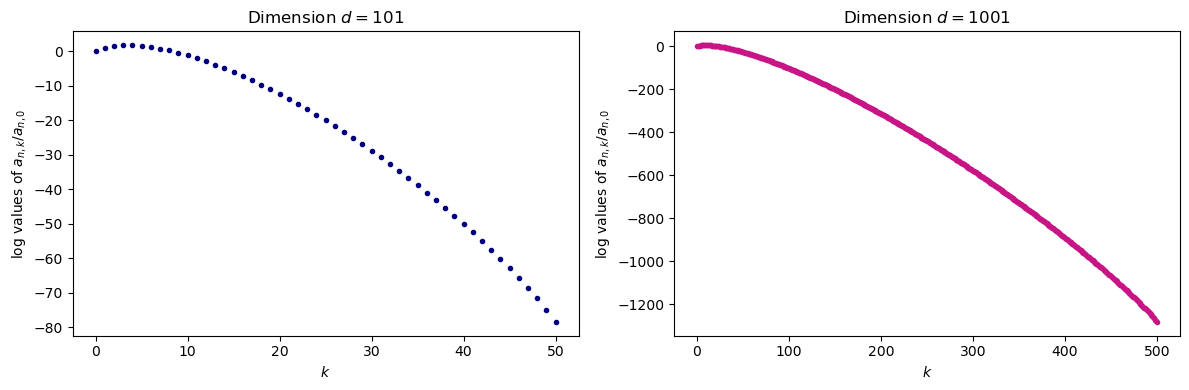

In [3]:
def compute_a(d, n):
  a = torch.ones(n+1,n+1, dtype=torch.int)
  for m in range(n):
    a[m+1, 0] = (d-2-2*m)*a[m, 0]
    for k in range(1, m+1):
        a[m+1, k] = (d-2 -2*m + k)*a[m, k] + a[m, k-1]
  return a

def compute_f(d, n):
  f = torch.arange(n+1, dtype=torch.float)
  f = torch.diag(f/2*(2*d-f-3))
  for m in range(2, n+1):
    f[m, 1] = (d-2*m)/(d-2*m+1+ f[m-1, 1])*f[m-1, 1]
    for k in range(2, m):
        f[m, k] = (d-2*m +k-1 + f[m-1, k-1])/(d-2*m+k+ f[m-1, k])*f[m-1, k]
  return f[1:,1:]

def get_loga(d):
  n = (d-1)//2
  Fn = compute_f(d, n)[-1,:]
  S = torch.zeros(n+1)
  S[:-1] = Fn.log10().flip(0).cumsum(0).flip(0)
  S = S - S[0]
  return S

# sanity check
d = 15
n = (d-1) //2
print(d, n)
logA1 = compute_a(d, n)[-1:].log10().squeeze()
logA1 =  logA1 - logA1[0]
logA2 = get_loga(d)
print("This should be almost zero:", torch.linalg.norm(logA1-logA2).item())
print(logA1)
print(logA2)

# get data for d=101 and d=1001
S101 = get_loga(101)
X101 = torch.arange(S101.shape[0])
np.savetxt(f"ank_101.dat", np.column_stack((X101, S101)))

S1001 = get_loga(1001)
X1001 = torch.arange(S1001.shape[0])
np.savetxt(f"../ank_1001.dat", np.column_stack((X1001, S1001)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) # Adjust figsize as needed

ax1.plot(X101,S101, color="navy", linestyle="none", marker=".")
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"log values of $a_{n,k}/a_{n,0}$")
ax1.set_title(rf"Dimension $d=101$")

ax2.plot(X1001,S1001, color="mediumvioletred", linestyle="none", marker=".")
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"log values of $a_{n,k}/a_{n,0}$")
ax2.set_title(rf"Dimension $d=1001$")

plt.tight_layout()
plt.show()


## Figure 3: Weight function of uniform samples from $B_1(0)$

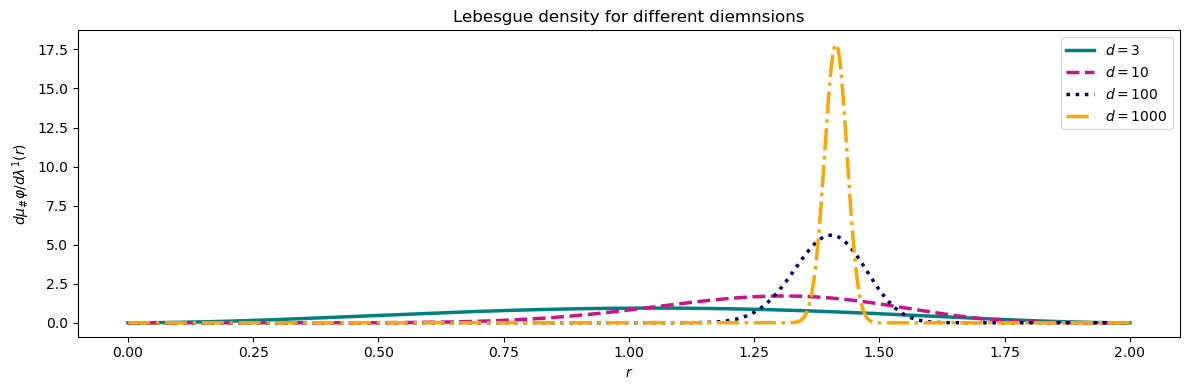

In [4]:
def muf(d, r):
  return d * r**(d-1) * special.betainc((d+1)/2, 0.5, 1 - r**2/4)

x = np.linspace(0, 2, 1000)
D = [3, 10, 100, 1000]
ls = ["-", "--", ":", "-."]
colors = ["teal", "mediumvioletred", "navy", "orange"]
DATA = np.zeros((5, 1000))
DATA[4] = x
plt.figure(figsize=(12, 4))
for j in range(len(D)):
    y = np.zeros_like(x)
    for k in range(len(x)):
        y[k] =  muf(D[j], x[k])
    plt.plot(x,y, label = rf"$d={D[j]}$", linestyle=ls[j], color=colors[j])
    DATA[j] = y
plt.legend()
plt.xlabel(r"$r$")
plt.ylabel(r"$d\mu _{\#}\varphi / d\lambda^1(r)$")
plt.title(r"Lebesgue density for different diemnsions")
plt.tight_layout()
plt.show()

header = "f1 f2 f3 f4 x"
np.savetxt('../weights_d.dat', DATA.T, header=header, comments="")

## Figure 4: Hypergeometric function $\eta_d$

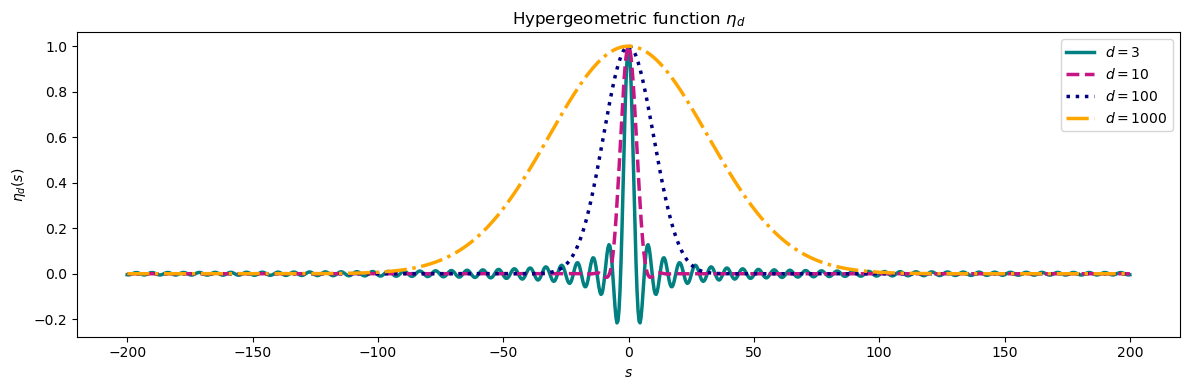

In [5]:
def S_cos(d, s, prec=25):
    """@return h_d(s)=S_d[cos](s) """
    mp.dps = prec
    d, s, = mpf(d), mpf(s)
    return hyp0f1(d/2,-s**2/4)

x = np.linspace(-200, 200, 1000)
D = [3, 10, 100, 1000]
ls = ["-", "--", ":", "-."]
colors = ["teal", "mediumvioletred", "navy", "orange"]
DATA = np.zeros((5, 1000))
DATA[4] = x
plt.figure(figsize=(12, 4))
for j in range(len(D)):
    y = np.zeros_like(x)
    for k in range(len(x)):
        y[k] = np.float64(S_cos(D[j], x[k]))
    plt.plot(x,y, label = rf"$d={D[j]}$", linestyle=ls[j], color=colors[j])
    DATA[j] = y
plt.legend()
plt.xlabel(r"$s$")
plt.ylabel(r"$\eta_d(s)$")
plt.title(r"Hypergeometric function $\eta_d$")
plt.tight_layout()
plt.show()

header = "f1 f2 f3 f4 x"
np.savetxt('../eta_d.dat', DATA.T, header=header, comments="")